In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt
import copy
from torch.utils.data.sampler import SubsetRandomSampler

Determine HyperParameter

In [59]:
learning_rate = 0.1
ModelList = []          ## list for models
Res = []
IItr = 12
batch_size = 64
n_clients = 10

Dataset distribution among clients

In [63]:
Avg = n_clients
Asking = [10]
MaxTime = 0
smooth = [50,100]
VGG = 0
CUDAA = 0
num_workers = 0
transform = transforms.ToTensor()
MaxItr = 1000
# It is in order of 50K dataset

train_data = torchvision.datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
temp = tuple([len(train_data)//n_clients for i in range(n_clients)])
dataset = torch.utils.data.random_split(train_data, temp)
worker_data_loader = []
for data_w in dataset:
    worker_data_loader.append(torch.utils.data.DataLoader(data_w, batch_size=batch_size, shuffle=True, num_workers=0))
test_data  = torchvision.datasets.MNIST(root = 'data', train = False, download = False, transform = transform)
testloader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False, num_workers=0)

Simple CNN

In [64]:
class model(nn.Module):
    def __init__(self):
        hidden_1 = 32
        hidden_2 = 32
        super(model, self).__init__()
        self.conv1 = nn.Conv2d(1,  16,  kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.fc1 = nn.Linear(32*10*10, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv2(x), 2))
        x = x.view(-1,32*10*10 )
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Using GPU if available

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [66]:
Fix_net = model().to(device) 
net = model().to(device)

In [67]:
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [68]:
Err_Storage = [[] for i in range(Avg+1)]
Time_Storage = [[] for i in range(Avg+1)]

In [69]:
def t(Kt, Avg):
    import numpy as np
    T = np.random.uniform(0,1,Avg)
    Time_Index  = sorted(range(len(T)), key = lambda kk: T[kk])
    Temp = Time_Index[0:Kt]
    Out = T[Temp[Kt-1]] 
    return Out, Temp

1. calculate loss on train data

In [75]:
def worker_new(Fix_net_state_dict, worker_data_loader, VGG, CUDAA):

    import torch
    import torch.nn as nn
    import torchvision
    import torchvision.transforms as transforms
    from torchvision import datasets, models, transforms
    import numpy as np
    import time


    train_loader = worker_data_loader
###################################################################################################################
        
    class model(nn.Module):
        def __init__(self):
            hidden_1 = 32
            hidden_2 = 32
            super(model, self).__init__()
            self.conv1 = nn.Conv2d(1,  16,  kernel_size=5)
            self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
            self.fc1 = nn.Linear(32*10*10, hidden_1)
            self.fc2 = nn.Linear(hidden_1, hidden_2)
            self.fc3 = nn.Linear(hidden_2, 10)
    
        def forward(self, x):
            x = nn.functional.relu(self.conv1(x))
            x = nn.functional.relu(nn.functional.max_pool2d(self.conv2(x), 2))
            x = x.view(-1,32*10*10 )
            x = nn.functional.relu(self.fc1(x))
            x = nn.functional.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    

    net_worker = model().to(device)
    net_worker.load_state_dict(Fix_net_state_dict)
    criterion = nn.CrossEntropyLoss()
    counterr = 0
    running_loss = 0
    
    for i, data in enumerate(train_loader, 0):
        counterr += 1
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net_worker(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        if counterr == 10:
            break

    return running_loss, net_worker.parameters()

2. Calulate loss on testdata

In [76]:
def Get_Res_Worker(param_master_loop):
    import torch
    import torch.nn as nn
    import torchvision
    import torchvision.transforms as transforms
    import numpy as np
    import time
    import matplotlib.pyplot as plt
    import copy
    classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
    
    Kt, Avg, learning_rate, Fix_net_state_dict, worker_data_loader, testloader, net, MaxItr, MaxTime, smooth, optimizer, criterion, VGG, CUDAA, batch_size = param_master_loop
    time_start = time.time()
    Itr = 0

    loss_workers = 0
    Err = []
    TTime = 0
    Time = []
    
    scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, step_size = smooth[1], gamma=0.9, last_epoch=-1)
    Itr = IItr
    
    
    
    while Itr < MaxItr:

        net_parameters = []
        optimizer.zero_grad()
        net.load_state_dict(Fix_net_state_dict)
        dict_param2 = dict(net.named_parameters())

        # Timing:
        T, Participated_Workers = t(Kt, Avg)
        TTime = T + TTime


        for i in Participated_Workers:
            loss_worker, temp = worker_new(Fix_net_state_dict, worker_data_loader[i], VGG, CUDAA)
            net_parameters.append(temp) 
            loss_workers += loss_worker/len(Participated_Workers)

        # Updating model                             
        for P in zip(net.parameters(), *net_parameters):
            temp = 0
            for p in P[1:]:
                temp += p.grad/len(Participated_Workers)
            P[0].grad = temp

        scheduler.step()
        optimizer.step() 

        
        for name, param in net.named_parameters():
            if name in dict_param2:
                dict_param2[name].data.copy_(param.data)
        Fix_net_state_dict = dict_param2         



        if Itr == 0:
            Time.append(TTime)
            Err.append(loss_workers)

        if Itr %smooth[0] == smooth[0]-1:
            Time.append(TTime)
            Err.append(loss_workers / smooth[0])
            loss_workers = 0


        Itr += 1

###################################################################################################################
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    with torch.no_grad():
        for data in testloader:

            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(10):
                
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    
    for i in range(10):
        print("testdata",'Number of workers:%d Accuracy of %5s : %2d %%' % (Kt, classes[i], 100 * class_correct[i] / class_total[i]))
    
    print('time elapsed', (time.time() - time_start)/60,' min')
        
    return Err, Time, Fix_net_state_dict

After Running the modules, run the following part for Error calculation

TestData

In [77]:
for i in Asking:
    Kt = i
    Fix_net_state_dict = copy.deepcopy(Fix_net.state_dict())

    param_master_loop = [Kt, Avg, learning_rate, Fix_net_state_dict,
                         worker_data_loader, testloader, net, MaxItr,
                         MaxTime, smooth, optimizer, criterion, VGG, CUDAA, batch_size]
    Err_Storage[i-1], Time_Storage[i-1], Fix_net_state_dict = Get_Res_Worker(param_master_loop)

ESS  = [x for x in Err_Storage if x]   
TSS = [x for x in Time_Storage if x] 



testdata Number of workers:10 Accuracy of     0 : 99 %
testdata Number of workers:10 Accuracy of     1 : 98 %
testdata Number of workers:10 Accuracy of     2 : 98 %
testdata Number of workers:10 Accuracy of     3 : 98 %
testdata Number of workers:10 Accuracy of     4 : 98 %
testdata Number of workers:10 Accuracy of     5 : 98 %
testdata Number of workers:10 Accuracy of     6 : 96 %
testdata Number of workers:10 Accuracy of     7 : 98 %
testdata Number of workers:10 Accuracy of     8 : 97 %
testdata Number of workers:10 Accuracy of     9 : 98 %
time elapsed 35.34883539676666  min


TrainData

Text(0.5, 1.0, 'Normalize loss on Traindata')

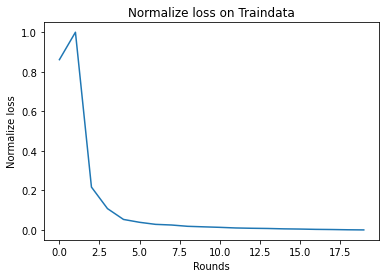

In [78]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

scaled_x = NormalizeData(ESS[0])

plt.plot(scaled_x)
plt.xlabel('Rounds')
plt.ylabel('Normalize loss')
plt.title('Normalize loss on Traindata')